In [1]:
# Libraries

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import NotFittedError
import warnings

In [2]:
# DATA PREPARATION & FEATURE ENGINEERING 

warnings.filterwarnings('ignore')

df = pd.read_excel('Sample_data.xlsx', sheet_name='Sheet1')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df['Measured_value'] = pd.to_numeric(df['Measured_value'], errors='coerce')
df.dropna(subset=['Measured_value'], inplace=True)

df['Day'] = df['Date'].dt.date
daily_df = df.groupby('Day').agg({
    'Measured_value': 'mean',
    'Label': lambda x: x.mode()[0] if not x.mode().empty else 'PASS'
}).reset_index()

daily_df['Label_encoded'] = daily_df['Label'].map({'PASS': 0, 'FAIL': 1})
daily_df['Day'] = pd.to_datetime(daily_df['Day'])


In [3]:
# Feature Engineering function to be reused

def create_features(df):
    df_out = df.copy()
    df_out['Day_num'] = (df_out['Day'] - df_out['Day'].min()).dt.days
    df_out['Day_of_week'] = df_out['Day'].dt.weekday
    df_out['Month'] = df_out['Day'].dt.month

    for i in range(1, 8):
        df_out[f'Lag{i}'] = df_out['Measured_value'].shift(i)

    for window in [3, 5, 7, 14]:
        df_out[f'Rolling_mean_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).mean()
        df_out[f'Rolling_std_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).std()
        df_out[f'Rolling_min_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).min()
        df_out[f'Rolling_max_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).max()

    df_out['EWM_3'] = df_out['Measured_value'].shift(1).ewm(span=3).mean()
    df_out['EWM_7'] = df_out['Measured_value'].shift(1).ewm(span=7).mean()

    df_out['day_of_week_sin'] = np.sin(2 * np.pi * df_out['Day_of_week']/6.0)
    df_out['day_of_week_cos'] = np.cos(2 * np.pi * df_out['Day_of_week']/6.0)
    df_out['month_sin'] = np.sin(2 * np.pi * df_out['Month']/12.0)
    df_out['month_cos'] = np.cos(2 * np.pi * df_out['Month']/12.0)

    if 'Lag1' in df_out.columns and 'Lag3' in df_out.columns and 'Lag7' in df_out.columns:
       
        temp_lag1 = df_out['Lag1'].fillna(method='bfill')
        df_out['day_week_sin_x_lag1'] = df_out['day_of_week_sin'] * temp_lag1
        df_out['day_week_cos_x_lag1'] = df_out['day_of_week_cos'] * temp_lag1
        df_out['day_num_x_lag1'] = df_out['Day_num'] * temp_lag1
        df_out['trend_3'] = df_out['Lag1'] - df_out['Lag3']
        df_out['trend_7'] = df_out['Lag1'] - df_out['Lag7']
        df_out['momentum_3'] = (df_out['Lag1'] - df_out['Rolling_mean_3']) / df_out['Rolling_std_3']
        df_out['momentum_7'] = (df_out['Lag1'] - df_out['Rolling_mean_7']) / df_out['Rolling_std_7']
        df_out['volatility_ratio'] = df_out['Rolling_std_3'] / df_out['Rolling_std_7']

    return df_out

In [4]:
# MODEL TRAINING 
#train and xgb mobel

featured_df = create_features(daily_df)
featured_df.dropna(inplace=True)
featured_df.reset_index(drop=True, inplace=True)

features = [col for col in featured_df.columns if col not in ['Day', 'Measured_value', 'Label', 'Label_encoded']]
X = featured_df[features]
y_reg = featured_df['Measured_value']

split_idx = int(len(X) * 0.8)
X_train_reg, X_test_reg = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

dtrain_reg = xgb.DMatrix(X_train_reg_scaled, label=y_train_reg)
dtest_reg = xgb.DMatrix(X_test_reg_scaled, label=y_test_reg)

single_model_params = {
    'objective': 'reg:squarederror', 'eval_metric': 'rmse',
    'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.8,
    'colsample_bytree': 0.8, 'seed': 42
}
reg_model = xgb.train(
    params=single_model_params, dtrain=dtrain_reg, num_boost_round=3000,
    evals=[(dtest_reg, 'eval')],
    callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)],
    verbose_eval=False
)
test_predictions = reg_model.predict(dtest_reg)

In [5]:
# Classification Model 
# xgbclassifier

def aggressive_threshold_search(y_true, y_proba, model_name):
    """
    Extremely aggressive threshold search prioritizing recall over precision.
    """
    thresholds = np.concatenate([
        np.linspace(0.001, 0.1, 50),
        np.linspace(0.1, 0.5, 20),
        [0.6, 0.7, 0.8, 0.9]
    ])
    
    results = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:

            if np.sum(y_pred) == 0: 
                tn = cm[0,0]
                fp = 0
                fn = np.sum(y_true == 1)
                tp = 0
            else: 
                tn = 0
                fp = np.sum(y_true == 0)
                fn = 0
                tp = cm[0,0]
                
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        recall_weight = 0.8
        precision_weight = 0.2
        custom_score = recall_weight * recall + precision_weight * precision
        
        results.append({
            'threshold': threshold, 'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
            'precision': precision, 'recall': recall, 'f1': f1,
            'custom_score': custom_score, 'predicted_positives': sum(y_pred)
        })
    
    results_df = pd.DataFrame(results)
    
    best_custom = results_df.loc[results_df['custom_score'].idxmax()]
    
    one_tp_results = results_df[results_df['tp'] >= 1]
    best_one_tp = one_tp_results.loc[one_tp_results['fp'].idxmin()] if not one_tp_results.empty else None
    
    print(f"      {model_name} - Aggressive Threshold Analysis:")

    return results_df, best_custom['threshold'], best_one_tp['threshold'] if best_one_tp is not None else best_custom['threshold']


X_clf = X.copy()
y_clf = daily_df['Label_encoded'].loc[X_clf.index]

fail_count = (y_clf == 1).sum()
base_pos_weight = (y_clf == 0).sum() / fail_count if fail_count > 0 else 100

# Testing a wide range of multipliers
multipliers = [5, 10, 20, 50, 100, 200, 300, 500, 750, 1000]
extreme_weights = [base_pos_weight * m for m in multipliers]

print("                                                     --- Cost-Sensitive Learning Setup ---\n")
print(f" Base positive weight: {base_pos_weight:.1f}")
print(f" Testing extreme weights: {[f'{w:.0f}' for w in extreme_weights]}\n")

cost_sensitive_results = {}

for weight in extreme_weights:
    print(f"--- Training with Weight: {weight:.0f} ---")
    clf_model = xgb.XGBClassifier(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=3,
        scale_pos_weight=weight,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1 
    )

    clf_model.fit(X_clf, y_clf)
    
    y_proba_extreme = clf_model.predict_proba(X_clf)[:, 1]
    
    threshold_results, best_threshold, one_tp_threshold = aggressive_threshold_search(
        y_clf, y_proba_extreme, f"XGB_Weight_{weight:.0f}"
    )
    
    optimal_threshold = one_tp_threshold
    
    y_pred_extreme = (y_proba_extreme >= optimal_threshold).astype(int)
    
    cm = confusion_matrix(y_clf, y_pred_extreme)
    tn, fp, fn, tp = cm.ravel()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"   Result for Weight {weight:.0f}: TP={tp}, FP={fp}, FN={fn},"
          f"Threshold={optimal_threshold:.4f}, Recall={recall:.4f}, Precision={precision:.4f}\n")
    
    cost_sensitive_results[weight] = {
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
        'recall': recall, 'precision': precision, 'threshold': optimal_threshold
    }

                                                     --- Cost-Sensitive Learning Setup ---

 Base positive weight: 59.2
 Testing extreme weights: ['296', '592', '1183', '2958', '5917', '11833', '17750', '29583', '44375', '59167']

--- Training with Weight: 296 ---
      XGB_Weight_296 - Aggressive Threshold Analysis:
   Result for Weight 296: TP=6, FP=0, FN=0,Threshold=0.0980, Recall=1.0000, Precision=1.0000

--- Training with Weight: 592 ---
      XGB_Weight_592 - Aggressive Threshold Analysis:
   Result for Weight 592: TP=6, FP=0, FN=0,Threshold=0.1211, Recall=1.0000, Precision=1.0000

--- Training with Weight: 1183 ---
      XGB_Weight_1183 - Aggressive Threshold Analysis:
   Result for Weight 1183: TP=6, FP=0, FN=0,Threshold=0.1211, Recall=1.0000, Precision=1.0000

--- Training with Weight: 2958 ---
      XGB_Weight_2958 - Aggressive Threshold Analysis:
   Result for Weight 2958: TP=6, FP=0, FN=0,Threshold=0.1421, Recall=1.0000, Precision=1.0000

--- Training with Weight: 5917 ---


In [6]:
# FUTURE PREDICTION LOOP
# xgb.dmetric 

future_steps = 30
future_predictions = []
future_failures = []
history_df = featured_df.copy()

for i in range(future_steps):
    
    last_day = history_df['Day'].iloc[-1]
    new_day = last_day + pd.Timedelta(days=1)

   
    new_row_df = pd.DataFrame({
        'Day': [new_day],
        'Measured_value': [np.nan], 
        'Label': [''], 'Label_encoded': [0]
    })
    
    temp_df = pd.concat([history_df, new_row_df], ignore_index=True)
    
   
    temp_featured = create_features(temp_df)
    
   
    X_future = temp_featured[features].iloc[-1:]
    X_future_scaled = scaler.transform(X_future)
    
   
    d_future_reg = xgb.DMatrix(X_future_scaled)
    predicted_value = reg_model.predict(d_future_reg)[0]
    
  
    predicted_proba_fail = clf_model.predict_proba(X_future_scaled)[:, 1][0]
    
   
    future_predictions.append({'Day': new_day, 'Predicted_Value': predicted_value})
    if predicted_proba_fail >= optimal_threshold:
        future_failures.append({'Day': new_day, 'Predicted_Value': predicted_value})

  
    history_df.loc[len(history_df)-1, 'Measured_value'] = predicted_value

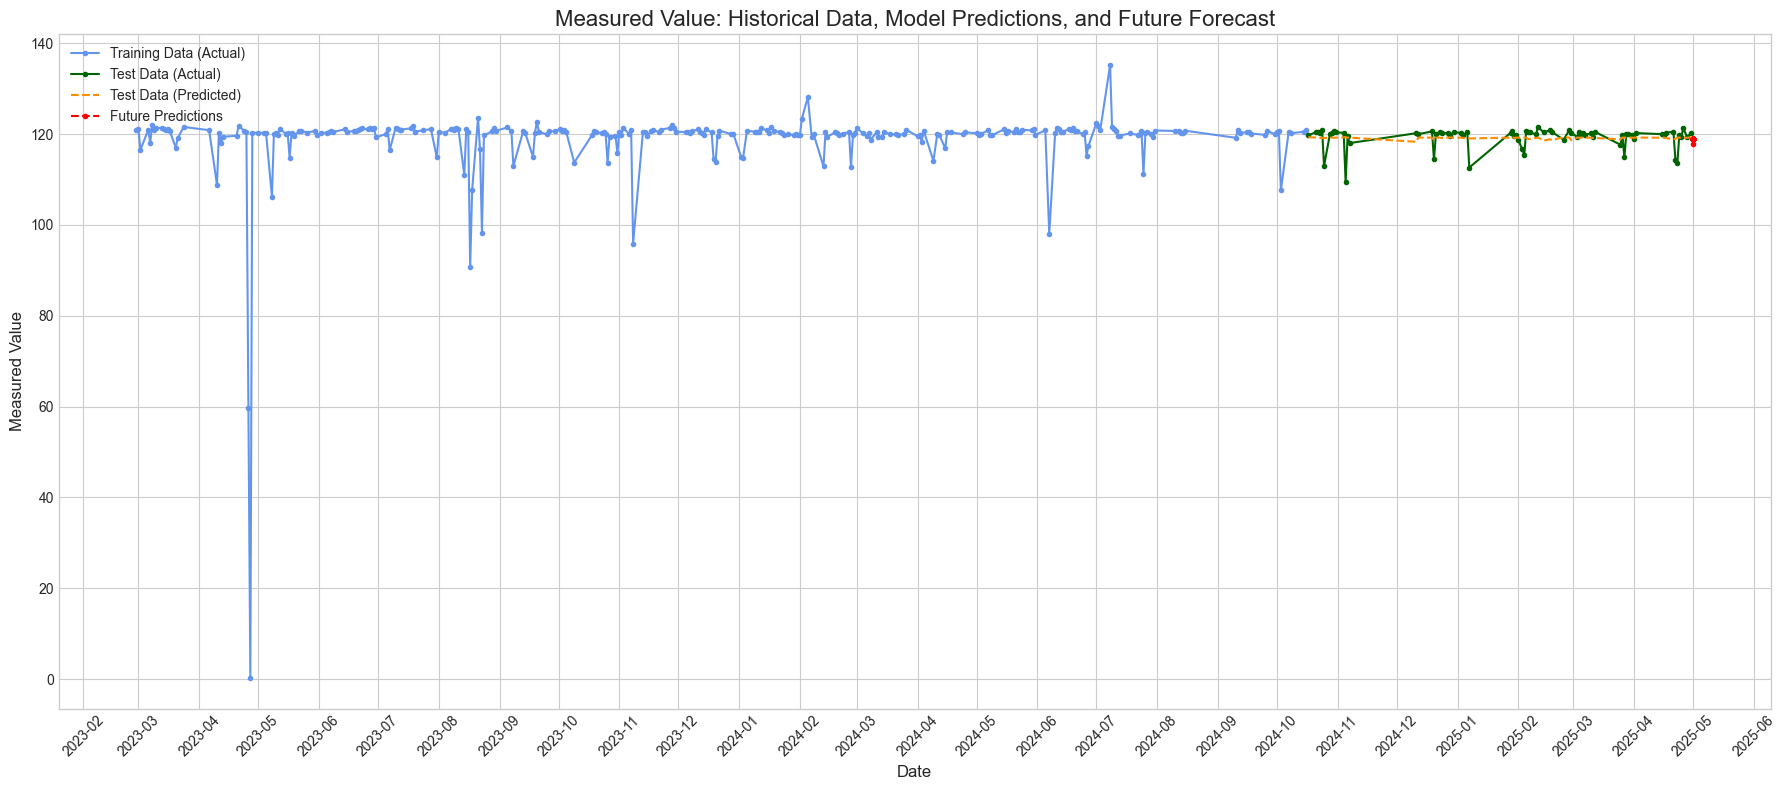

In [7]:
# Graph ploting

future_pred_df = pd.DataFrame(future_predictions)
future_fail_df = pd.DataFrame(future_failures)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(featured_df['Day'].iloc[:split_idx], y_train_reg,
        label='Training Data (Actual)', color='cornflowerblue', marker='.', linestyle='-')
ax.plot(featured_df['Day'].iloc[split_idx:], y_test_reg,
        label='Test Data (Actual)', color='darkgreen', marker='.', linestyle='-')

ax.plot(featured_df['Day'].iloc[split_idx:], test_predictions,
        label='Test Data (Predicted)', color='darkorange', marker='', linestyle='--')

if not future_pred_df.empty:
    ax.plot(future_pred_df['Day'], future_pred_df['Predicted_Value'],
            label='Future Predictions', color='red', marker='.', linestyle='--')

# Highlight future failures with a red 'X'
if not future_fail_df.empty:
    ax.scatter(future_fail_df['Day'], future_fail_df['Predicted_Value'],
               label='Predicted Future Failure', color='red', marker='X', s=150, zorder=5)

ax.set_title('Measured Value: Historical Data, Model Predictions, and Future Forecast', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Measured Value', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('measured_value.png')
plt.show()